#  Entrenamiento de modelos de regresión

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Creamos el directorio `images/training_linear_models`  (si aún no existe), y definimos la función `save_fig()` para guardar las imágenes
de este notebook

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "training_linear_models"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Regresión Lineal

## La Ecuación Normal

In [5]:
import numpy as np

np.random.seed(42)  # Esto hace que este ejemplo sea igual para todos los alumnos
m = 100  # número de instancias
X = 2 * np.random.rand(m, 1)  # vector columna
y = 4 + 3 * X + np.random.randn(m, 1)  # vector columna

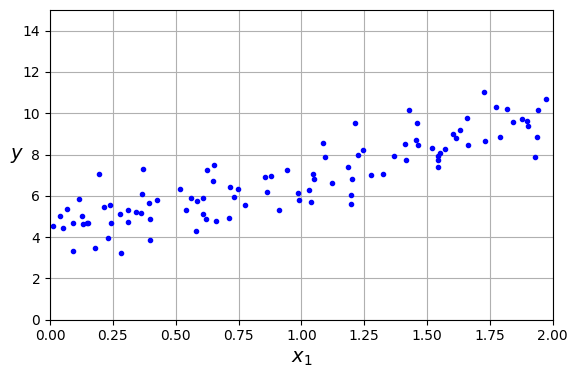

In [6]:
# Dibujamos el diagrama de dispersión

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
save_fig("generated_data_plot")
plt.show()

In [7]:
from sklearn.preprocessing import add_dummy_feature
X_b = add_dummy_feature(X)  # Al vector X le añade un uno a cada instancia
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

In [8]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [9]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # Al vector X le añade un uno c
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

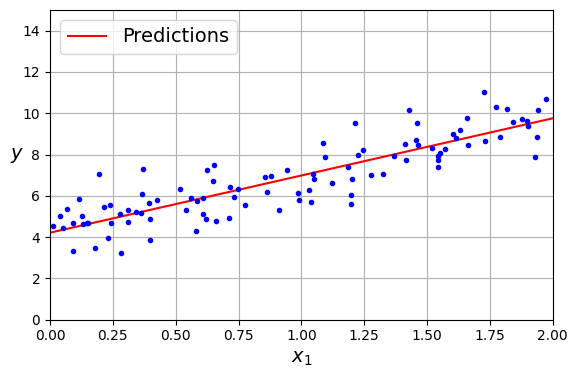

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  # ajustamos el formato
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")


plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")
save_fig("linear_model_predictions_plot")

plt.show()

In [11]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression() #Este algoritmo se basa en la pseudoinversa de X, será la que más usemos
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_ #obtenemos el interceto y la pendiente

(array([4.21509616]), array([[2.77011339]]))

In [12]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

El algorimo `LinearRegression` se basa en la función `scipy.linalg.lstsq()` la cual puede llamarse directamente

In [13]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

Esta función calcula $\mathbf{X}^+\mathbf{y}$, donde $\mathbf{X}^{+}$ es la pseudoinversa de $\mathbf{X}$ (concretamente la inversa Moore-Penrose). La podemos usar directamente `np.linalg.pinv()` para calcular la pseudoinversa:

In [14]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

# Gradiente Descendente
## Descenso del gradiente por lotes

In [15]:
eta = 0.1  # Tasa de aprendizaje
n_epochs = 1000 #Número de iteraciones, se le conoce como épocas
m = len(X_b)  # Número de instancias

np.random.seed(42)
theta = np.random.randn(2, 1)  # Parámetros del modelo incializados aleatoriamente

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

Una vez entrenado el modelo obtenemos sus parámetros

In [16]:
theta

array([[4.21509616],
       [2.77011339]])

A continuación vamos a generar los gráficos de como afecta la tasa de aprendizaje al algoritmo

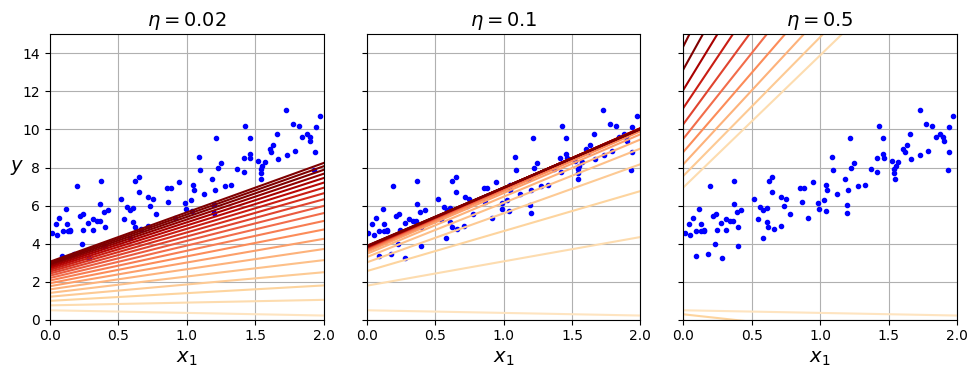

In [17]:
import matplotlib as mpl
# Definimos una función para calcular gradiente y obtener diferentes modelos (líneas de regresión)
def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

np.random.seed(42)
theta = np.random.randn(2, 1)  # Inicializamos los valores de theta

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)
save_fig("gradient_descent_plot")
plt.show()

## Descenso de gradiente estocástico

In [18]:
theta_path_sgd = []  # Necesitamos almacenar la ruta de theta en el espcio de theta para dibujar la figura

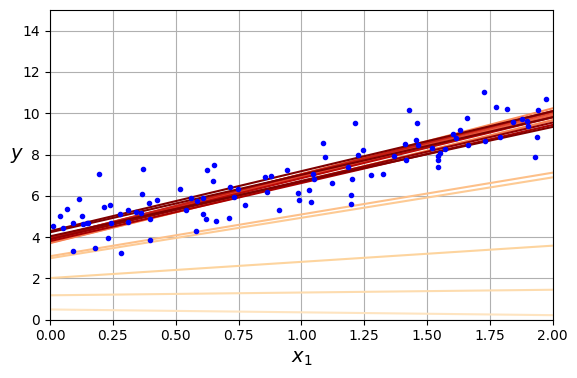

In [19]:
n_epochs = 50
t0, t1 = 5, 50  # Hiperparámetros del esquema de aprendizaje

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # Inicializamos theta_0 y theta_1

n_shown = 20  # Generamos 20 lineas de regresión
plt.figure(figsize=(6, 4))  # sólo para dar formato

for epoch in range(n_epochs):
    for iteration in range(m):

        # Estas líneas las usamos para generar la figura
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)

        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)  # for SGD, do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)  # extra code – to generate the figure

# extra code – this section beautifies and saves Figure 4–10
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
save_fig("sgd_plot")
plt.show()

In [20]:
theta

array([[4.21076011],
       [2.74856079]])

In [21]:
from sklearn.linear_model import SGDRegressor
# Este es el algoritmo descenso del gradiente estocástico SGDR
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() porque tenemos que aplanar el verctor y, es necesario incluso si es una matriz de una columna


,loss,'squared_error'
,penalty,None
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,1e-05
,shuffle,True
,verbose,0
,epsilon,0.1
,random_state,42


In [22]:
sgd_reg.intercept_, sgd_reg.coef_ # Obtenemos los valores del intercepto y la pendiente

(array([4.21278812]), array([2.77270267]))

# Regresión Polinomial

In [23]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

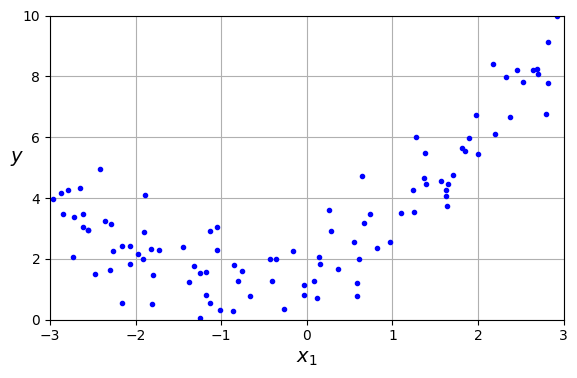

In [24]:
# extra code – this cell generates and saves Figure 4–12
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("quadratic_data_plot")
plt.show()

In [25]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [26]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [27]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

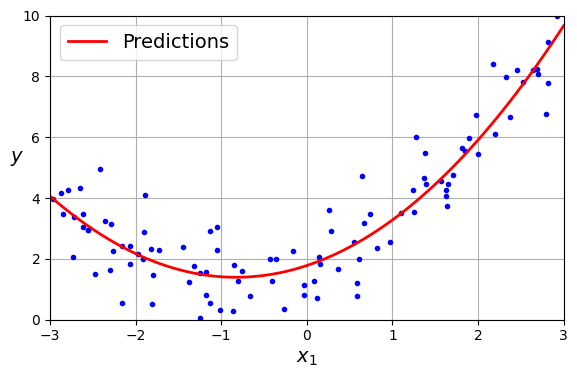

In [28]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("quadratic_predictions_plot")
plt.show()

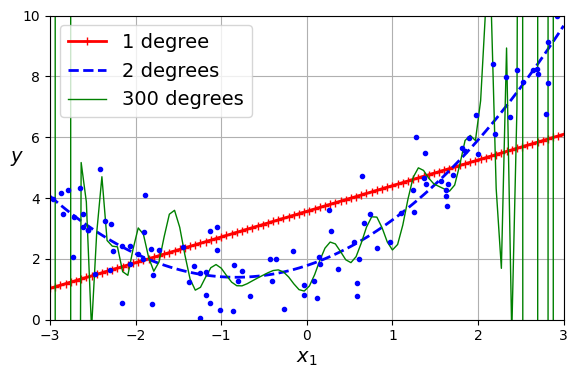

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(6, 4))

for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("high_degree_polynomials_plot")
plt.show()

# REGRESIÓN LOGÍSTICA

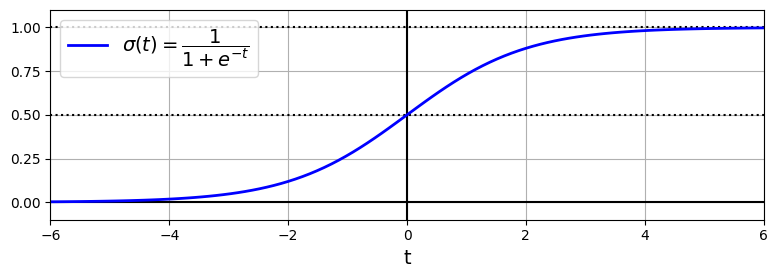

In [30]:
#Código extra para generar la imagen
lim = 6
t = np.linspace(-lim, lim, 100)
sig = 1 / (1 + np.exp(-t))

plt.figure(figsize=(8, 3))
plt.plot([-lim, lim], [0, 0], "k-")
plt.plot([-lim, lim], [0.5, 0.5], "k:")
plt.plot([-lim, lim], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \dfrac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left")
plt.axis([-lim, lim, -0.1, 1.1])
plt.gca().set_yticks([0, 0.25, 0.5, 0.75, 1])
plt.grid()
save_fig("logistic_function_plot")
plt.show()

### LÍMITES DE DECISIÓN

Vamos a utilizar un dataset que se encuentra en la libreria sklearn

In [31]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [32]:
print(iris.DESCR) #Imprime una descripción completa del dataset

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [33]:
iris.data.head(3) # Ten encuenta que las instancias no estan barajadas

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [34]:
iris.target_names #Obtenemos un listado de las diferentes clases

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Vamos a entrenar el modelo para que nos detecte si una instancia pertenece o no a la clase virgínica
según el valor del ancho del pétalo
Dividimos el conjunto de datos en datos de entrenamiento y datos de test

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Creamos un array con 1000 datos comprendido entre los valores del 0 al 3 y lo convierte un vector 
A continuación probamos nuestro modelo 
Calcula y almacena el punto exacto en el eje x donde la probabilidad de que un muestra pertenezca a la 
clase positiva es igual o supera el 50%
El resto es dibujar la gráfica

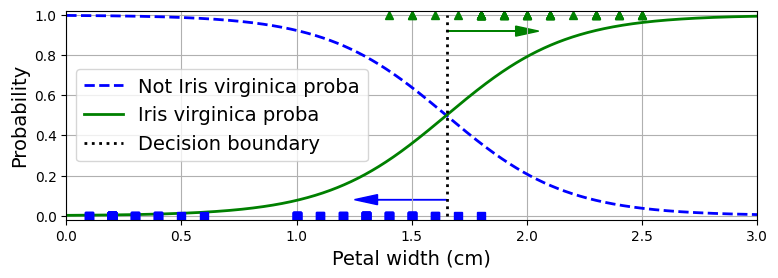

In [36]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)  # C
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

plt.figure(figsize=(8, 3))  
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2,
         label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica proba")
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2,
         label="Decision boundary")

# Decoramos la figura y la salvamos
plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(x=decision_boundary, y=0.92, dx=0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="g", ec="g")
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(loc="center left")
plt.axis([0, 3, -0.02, 1.02])
plt.grid()
save_fig("logistic_regression_plot")

plt.show()

In [37]:
decision_boundary

np.float64(1.6516516516516517)

Le damos dos valores a nuestro modelo para que prediga si pertenece o no a la clase virgínica

In [38]:
log_reg.predict([[1.7], [1.5]])

array([ True, False])

En este otro ejemplo incluimos dos caracaterísticas: la anchura del pétalo y su longitud
Entrenamos el modelo para que prediga, según las dos características, si pertenece o no a la calse virgínica.

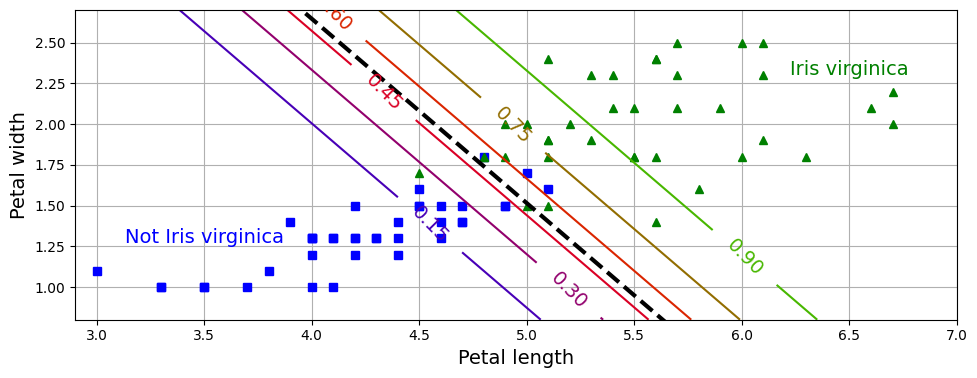

In [39]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)

# Para el contorno
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1),
                     np.linspace(0.8, 2.7, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()] 
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

# Límite de decisión
left_right = np.array([2.9, 7])
boundary = -((log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0])
             / log_reg.coef_[0, 1])

plt.figure(figsize=(10, 4))
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs")
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "g^")
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.27, "Not Iris virginica", color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", color="g", ha="center")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([2.9, 7, 0.8, 2.7])
plt.grid()
save_fig("logistic_regression_contour_plot")
plt.show()


La línea discontínua representa los puntos donde el modelo calcula una probabilidad del 50%
Como puedes apreciar es un límite lineal, las diferentes líneas paralelas indican las probalidades
Todas la flores que tienen más allá de la línea superior tienen una probabilidad del 90% de ser virginica